# Problem Statement

Studies have shown that increasing a person's literacy level can lead to higher income on average. Here, let's build a simple logistic regression model to predict income_bracket based on education type & number of education years in addition to other variables. More importantly, this serves to demonstrate how to go about selecting ideal probability thresholds using the confusion matrix and ROC curve so as to improve the model's accuracy.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
main = pd.read_csv('census_adult_income')
main.head()

,age,workclass,functional_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,297847,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,72,Private,74141,9th,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,48,United-States,>50K
2,45,Private,178215,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
3,31,Private,86958,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,55,Private,176012,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K


# Data Pre-processing

Data obtained is dirty & contains ' ?' for 3 columns: workclass,native_country,occupation.
Let's replace errorenous workclass & occupation values with mode of rows with the same work_hours. The hypothesis is that
jobs with certain work_hours tend to belong to specific workclass & occupation values. Next, let's replace errorneous 
native_country with 'United-States' since it's the most-common native_country value.

In [3]:
len(main[main['workclass']==' ?'])

1836

In [4]:
len(main[main['native_country']==' ?'])

583

In [5]:
len(main[main['occupation']==' ?'])

1843

In [6]:
#In fact, all rows with errorneous workclass values also have errorneous occupation values
len(main[(main['occupation']==' ?') & (main['workclass']==' ?')])

1836

In [7]:
main_copy = main.copy()
for i in range(len(main_copy)):
    if main_copy['occupation'][i] == ' ?':
        main_copy['occupation'][i] = main_copy[(main_copy['occupation'] != ' ?') & (main_copy['hours_per_week'] == main_copy['hours_per_week'][i])]['occupation'].mode()[0]
    if main_copy['workclass'][i] == ' ?':
        main_copy['workclass'][i] = main_copy[(main_copy['workclass'] != ' ?') & (main_copy['hours_per_week'] == main_copy['hours_per_week'][i])]['workclass'].mode()[0]  
    if main_copy['native_country'][i] == ' ?':
        main_copy['native_country'][i] = 'United-States'              

C:\Users\weiquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\weiquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\weiquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Exploratory Data Analysis

Let's begin with the statistical sumamry of continuous variables

In [8]:
main_copy.describe()

,age,functional_weight,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Age

Let's examine distribution of age using a kernel density plot.
The resulting plot shows that over half of the individuals are less than 40 years old.

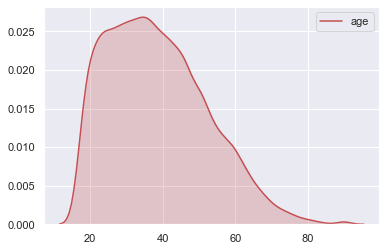

In [9]:
sns.kdeplot(main_copy['age'],shade=True,color='r')

Let's examine the ages with the most count for each workclass.
This can be done by grouping the data by age before doing a value_counts for workclass.
The following summarizes the steps into one function so that it can be resued for other columns. 
Observe that most Private workclass & Unemployed individuals are really young. Those holding government jobs 
tend to be in their 40s.

In [10]:
def show_max(inp_col):
    df = pd.DataFrame({'count' : main_copy.groupby(["age"])[inp_col].value_counts()}).reset_index()
    to_keep = []
    for i in df[inp_col].unique():
        new_df = df[df[inp_col] == i]
        to_keep.append(new_df.index[new_df['count'] == new_df['count'].max()][0])    
    df_max = df[df.index.isin(to_keep)] 
    return df_max
show_max('workclass')    

,age,workclass,count
13,18,Never-worked,3
20,19,Without-pay,2
42,23,Private,779
154,41,Local-gov,80
160,42,Self-emp-not-inc,89
168,43,State-gov,52
186,46,Federal-gov,41
211,50,Self-emp-inc,41


Let's examine the ages with the most count for each education. Observe that most individuals with only high-school education tend to be very young or very old. As level of education increases, most individuals posessing that level of education tend to be older. 

In [11]:
show_max('education')

,age,education,count
0,17,11th,180
1,17,10th,138
3,17,9th,25
11,18,12th,60
30,20,Some-college,413
100,25,Bachelors,205
136,27,5th-6th,16
162,29,Assoc-voc,60
253,35,HS-grad,320
335,40,Assoc-acdm,47


Let's examine the ages with the most count for each marital_status. Interestingly, most individuals who are never married tend to be very young. Most individuals who are divorced tend to be aged 45. Those widowed tend to be old.

In [12]:
show_max('marital_status')

,age,marital_status,count
31,23,Never-married,717
73,29,Married-spouse-absent,15
74,29,Married-AF-spouse,3
99,33,Separated,45
128,38,Married-civ-spouse,499
174,45,Divorced,178
277,62,Widowed,41


Let's examine the ages with the most count for occupation. Unsurprisingly, those holding managerial positions tend to be near their 40s.

In [13]:
show_max('occupation')

,age,occupation,count
7,17,Priv-house-serv,8
14,18,Sales,116
26,19,Other-service,232
42,20,Handlers-cleaners,81
79,23,Adm-clerical,137
91,23,Armed-Forces,2
97,24,Machine-op-inspct,74
114,25,Tech-support,42
182,30,Protective-serv,28
247,35,Farming-fishing,35


Let's examine the ages with most count for each relationship. Married inidividuals tend to be near their 40s.

In [14]:
show_max('relationship')

,age,relationship,count
11,19,Own-child,501
13,19,Other-relative,58
59,27,Not-in-family,304
115,36,Unmarried,134
116,36,Wife,62
119,37,Husband,445


Let's examine the ages with most count for each race. Whites & Blacks tend to be older.

In [15]:
show_max('race')

,age,race,count
32,23,Asian-Pac-Islander,40
48,26,Other,17
73,31,Amer-Indian-Eskimo,16
81,33,Black,105
95,36,White,763


Let's examine the ages with most count for each sex. Males tend to be alot older than females.

In [16]:
show_max('sex')

,age,sex,count
7,20,Female,363
36,35,Male,630


Workclass

Let's examine count of each workclass using bar plot.
The following function is created for plotting bar plots of specified column.

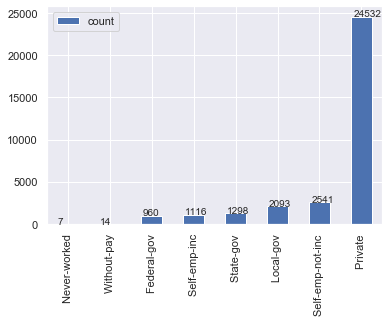

In [17]:
def bar_count(col):
    ax = main_copy[col].value_counts().to_frame(name = 'count').sort_values('count').plot.bar()
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x() * 1.01, p.get_height() * 1.005))
bar_count('workclass')        

Let's examine education grouped by workclass.
Observe that most individuals holding a government job has some form of degree while most who have never worked only
has high-school education.

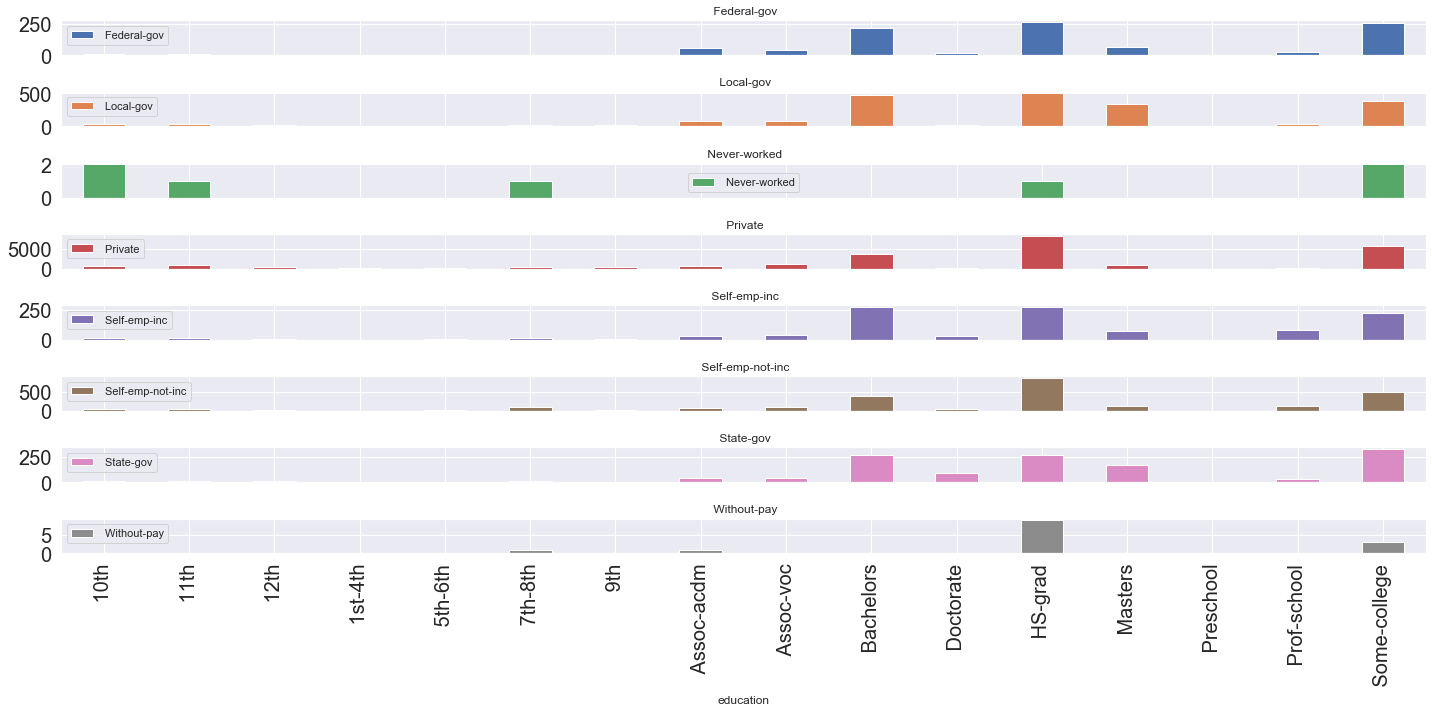

In [18]:
def group_bar(col,grp_col):
    df = main_copy.groupby(col)[grp_col].value_counts().unstack().T
    ax_bar = df.plot(kind='bar',subplots=True, figsize=(20,10),fontsize=20)
    plt.tight_layout()
group_bar('workclass','education')    

Let's examine marital status grouped by workclass.
Observe that for most workclass, married individuals exceed those who are never-married except for individuals
who have never-worked.

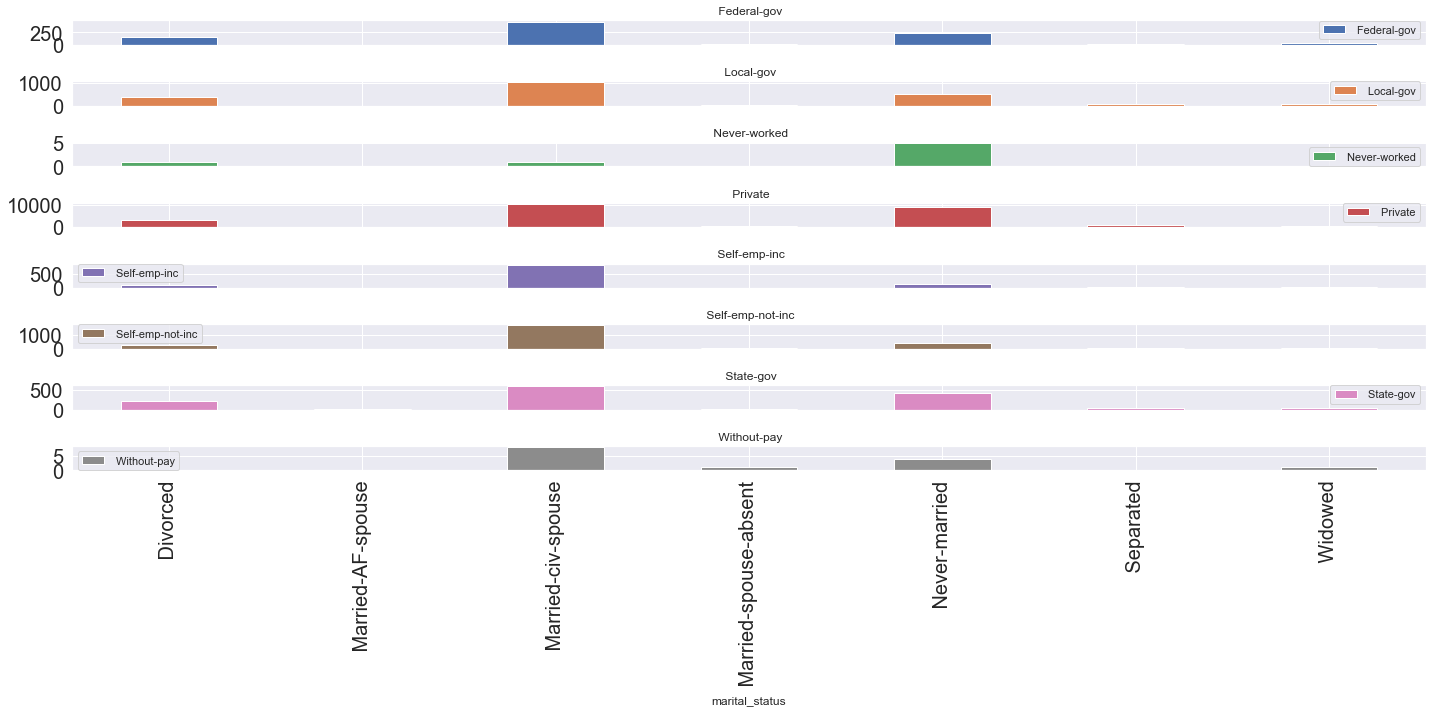

In [19]:
group_bar('workclass','marital_status')

Let's examine occupation grouped by workclass.
Notice a few interesting observations. Most individuals working in Federal-gov are working as clerks.
Most individuals workinf in Local-gov are working as Prof-specialty. Those who have Never-worked are
in either Craft-repair or Other-service. Private workclass has the most variety of occupations while 
those who are in Self-emp-inc/Self-emp-not-inc tend to have Exec-managerial/Sales roles. State-gov 
individuals tend to work as Prof-specialty while those Without-pay are primarily from Farming-fishing.

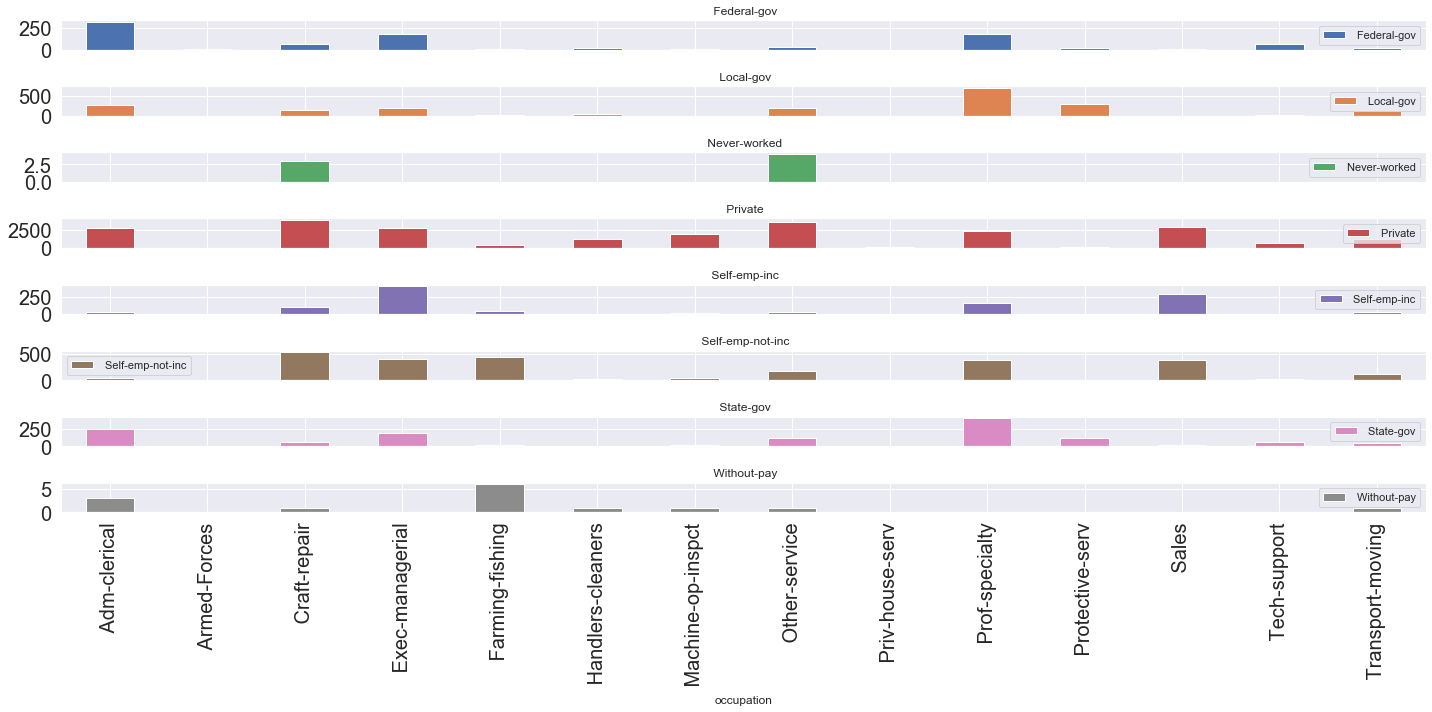

In [20]:
group_bar('workclass','occupation')

Let's examine relationship grouped by workclass. 
Observe that most individuals who have Never-worked are Own-child.

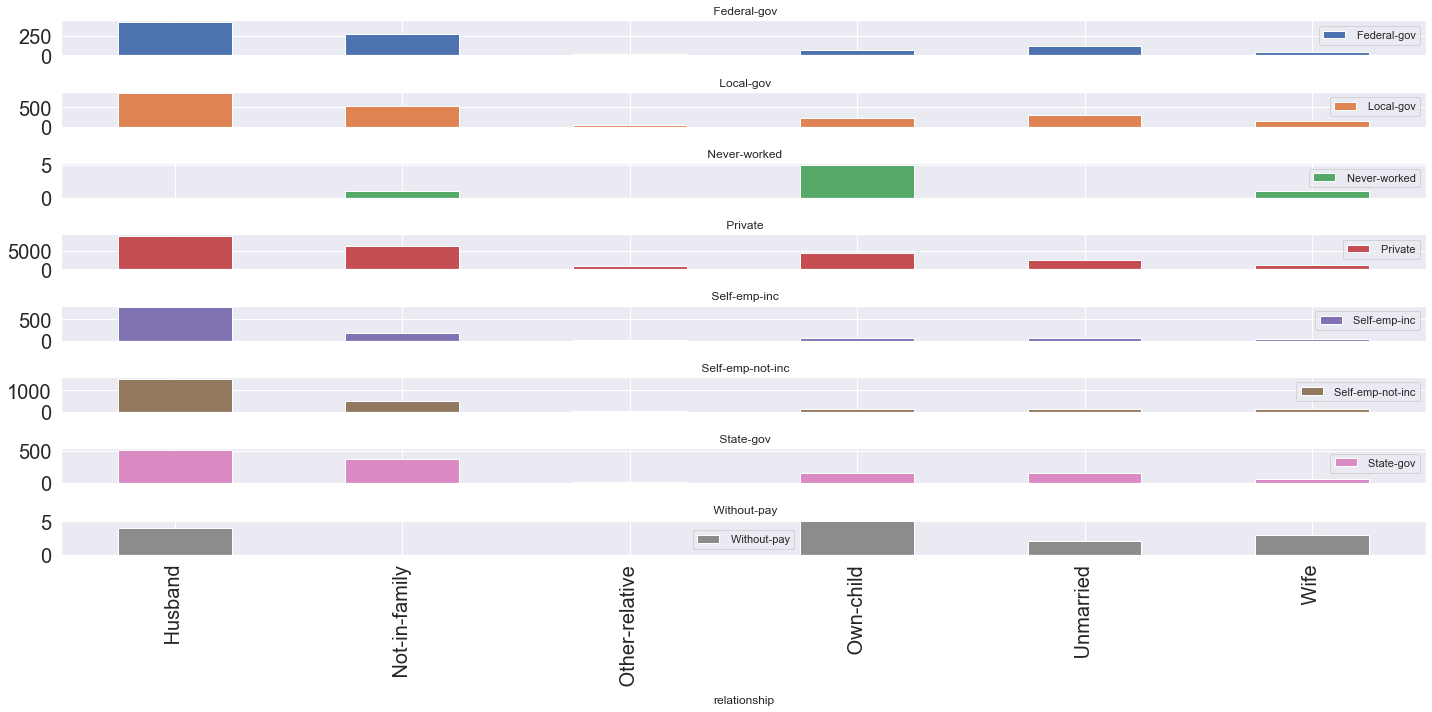

In [21]:
group_bar('workclass','relationship')

Let's examine race grouped by workclass.
Not surprisingly, most of Whites given the race imbalance in the data although the highest proportion of Blacks have Never-worked.

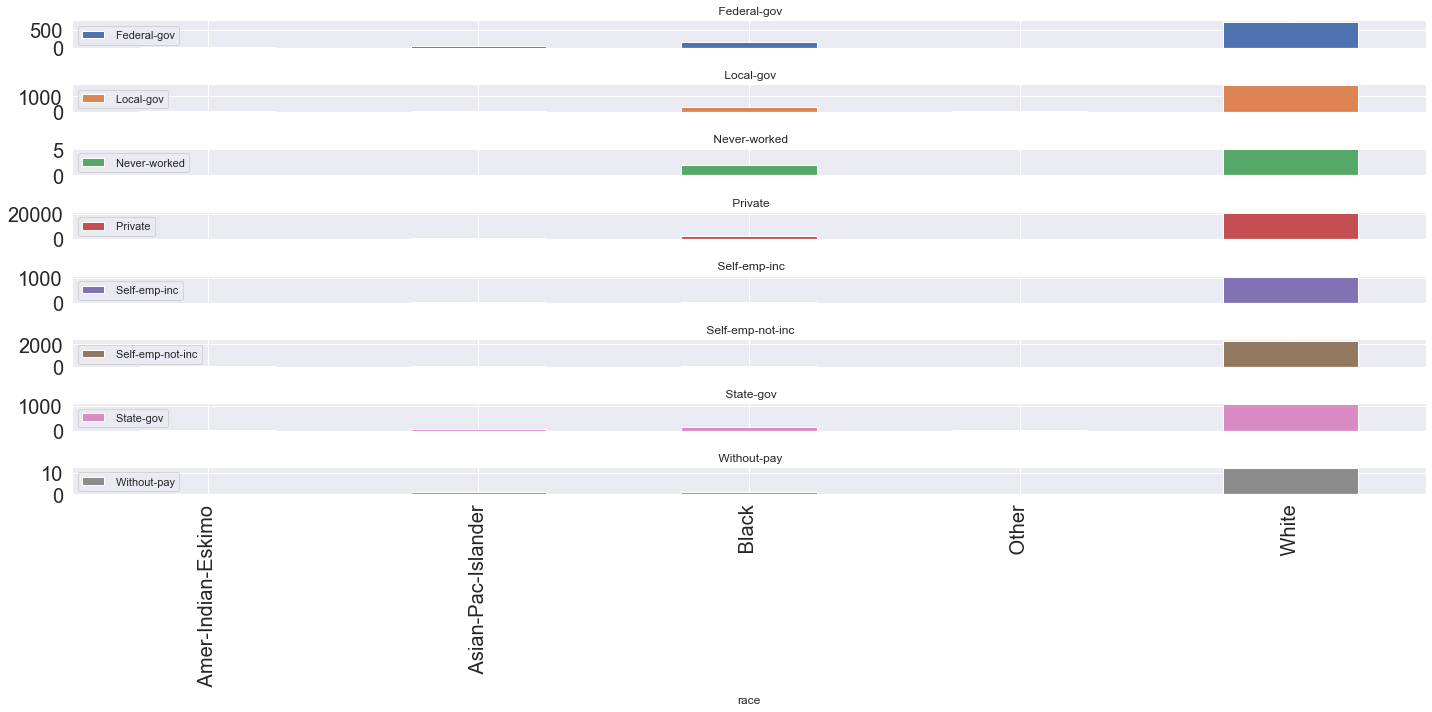

In [22]:
group_bar('workclass','race')

Let's examine sex grouped by workclass. 
Observe that self-employed face the highest gender-imbalance.

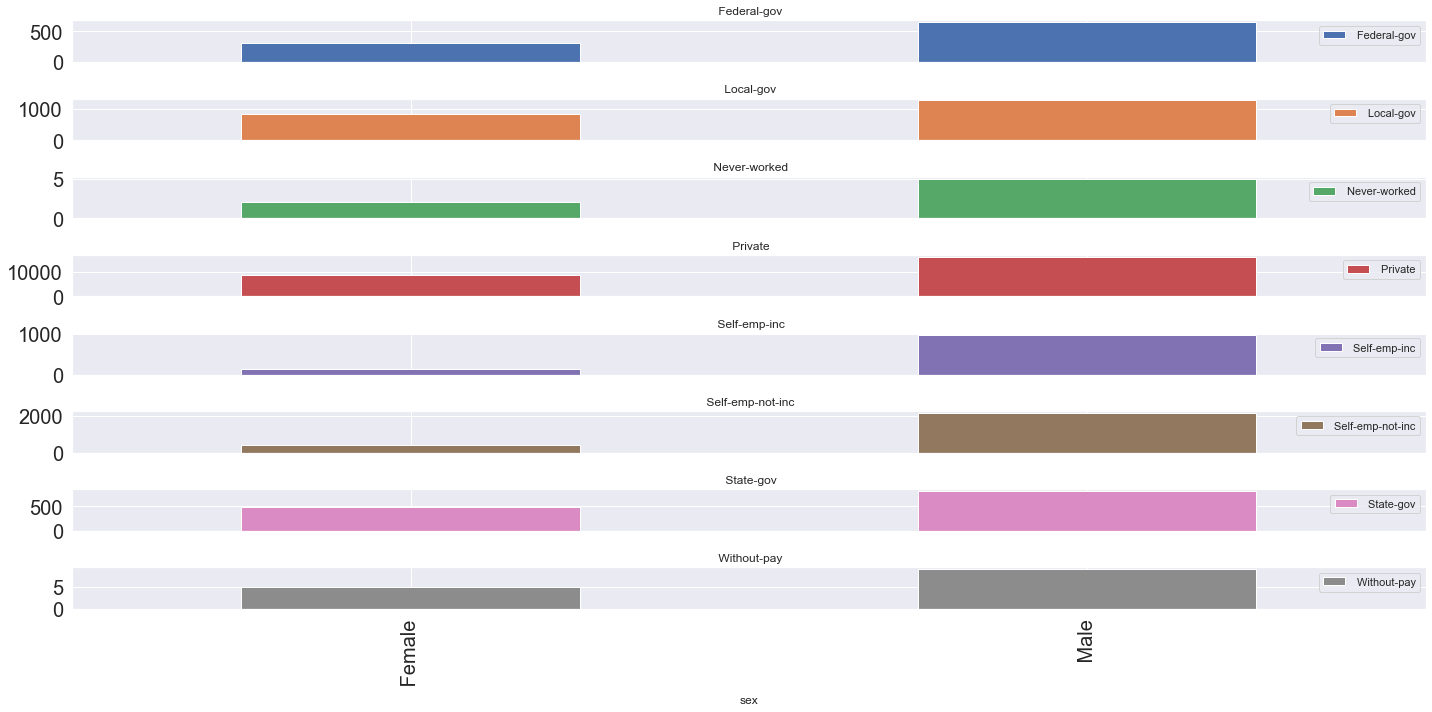

In [23]:
group_bar('workclass','sex')

Education

Let's examine count of each education.
Observe that most individuals belong to HS-grad.

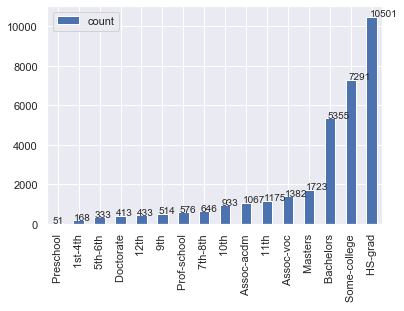

In [24]:
bar_count('education')

Let's examine marital_status grouped by education

C:\Users\weiquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  after removing the cwd from sys.path.


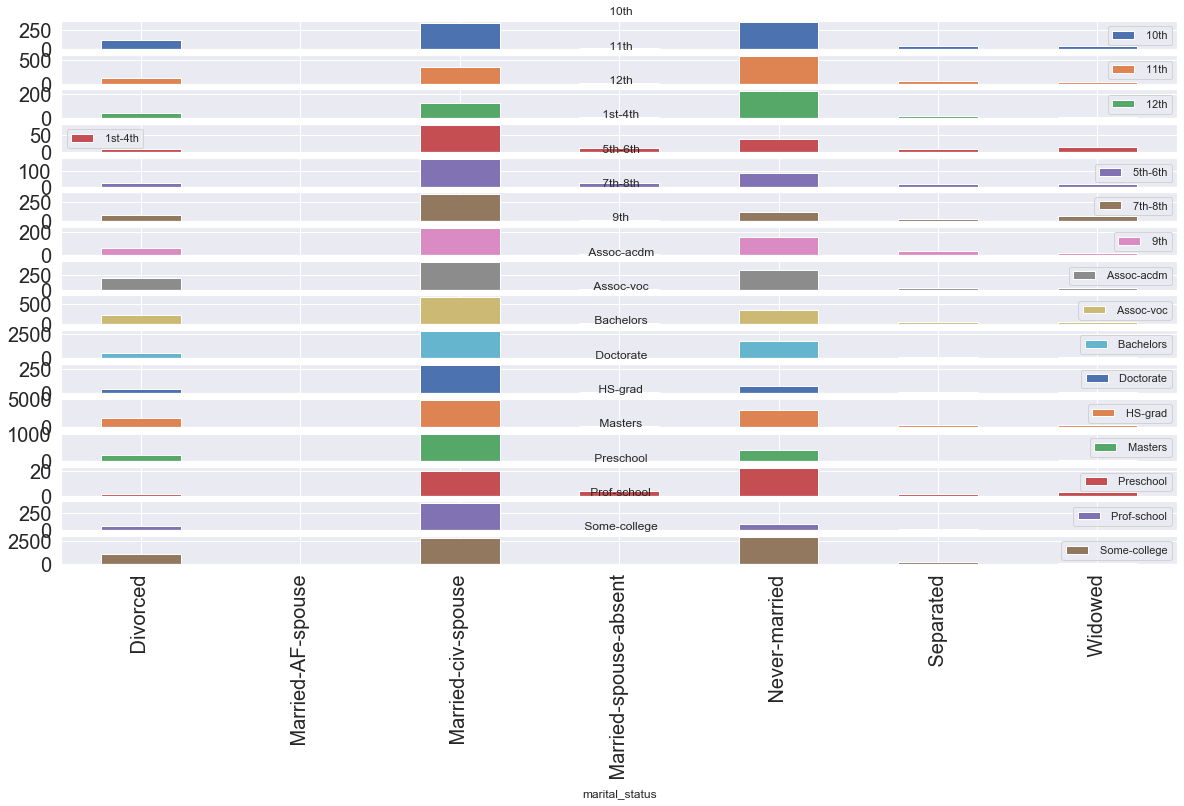

In [25]:
group_bar('education','marital_status')

Let's examine occupation grouped by education.
Observe that most individuals who had less than high-school education are working in Craft-repair & Other-service.
Those who has Doctorate tend to be in Exec-managerial or Prof-specialty.

C:\Users\weiquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  after removing the cwd from sys.path.


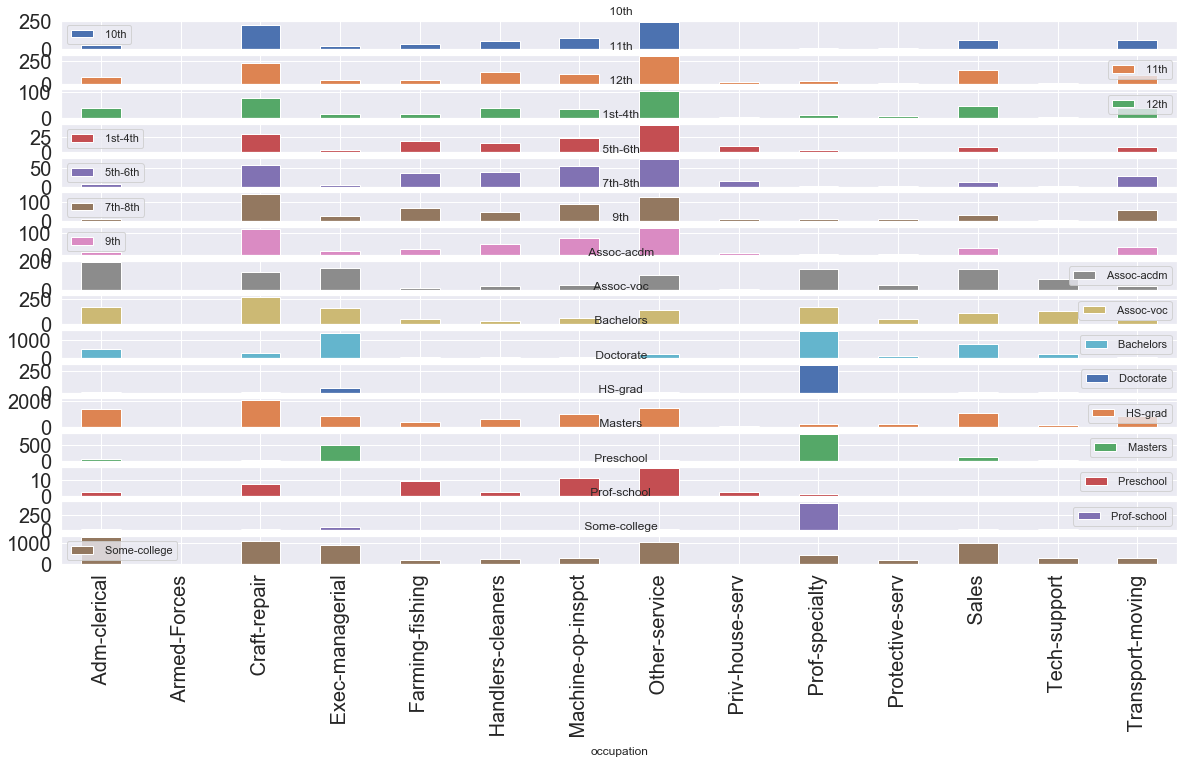

In [26]:
group_bar('education','occupation')

Let's examine relationship grouped by education

C:\Users\weiquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  after removing the cwd from sys.path.


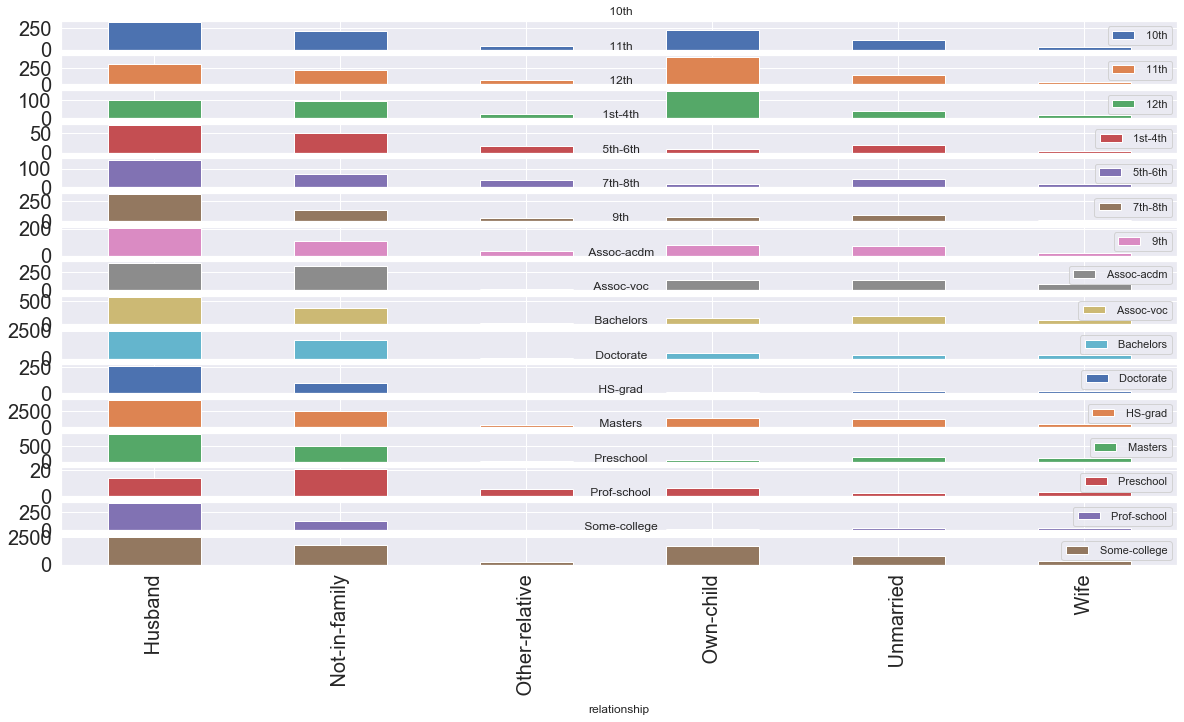

In [27]:
group_bar('education','relationship')

Let's examine race grouped by education

C:\Users\weiquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  after removing the cwd from sys.path.


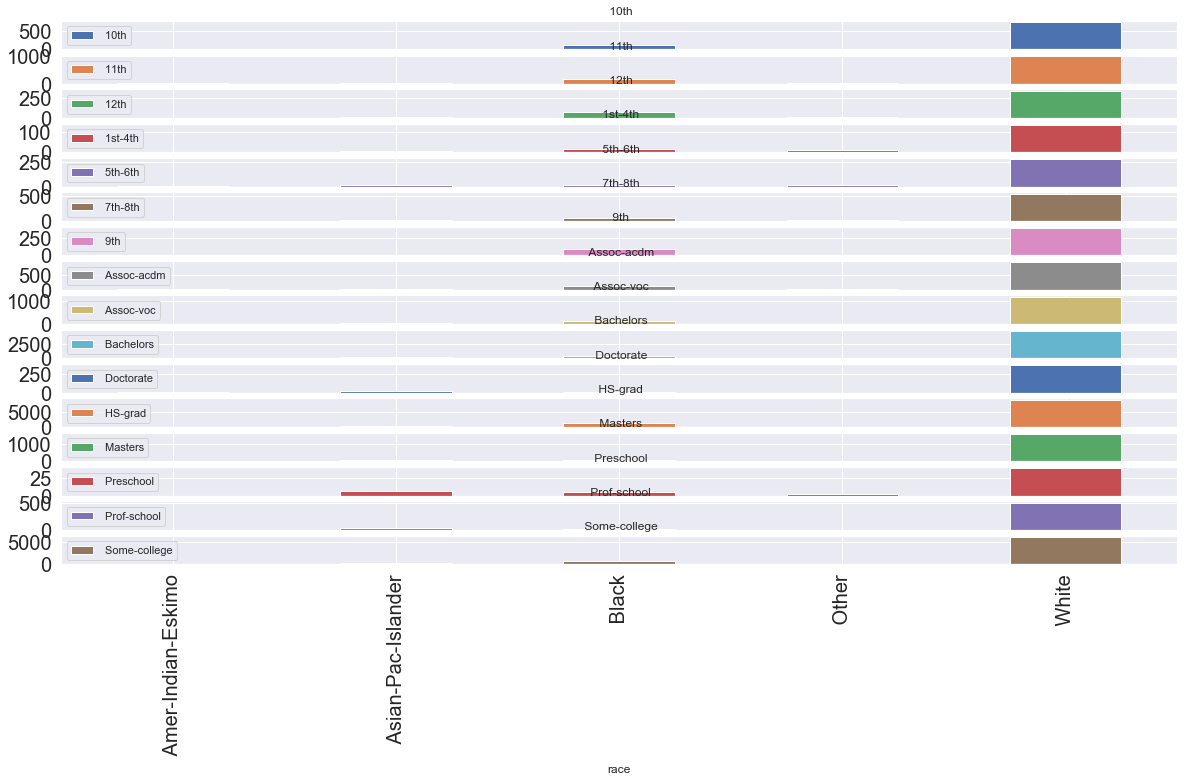

In [28]:
group_bar('education','race')

Marital_status

Let's examine count of each marital_status.
Observe that most are either Married-civ-spouse or never-married.

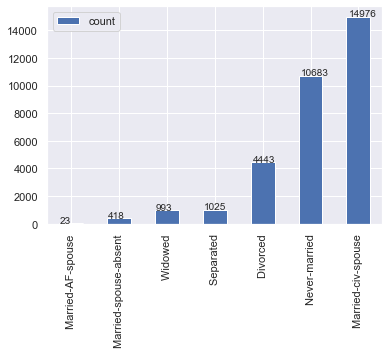

In [29]:
bar_count('marital_status')

Let's examine occupation grouped by marital_status

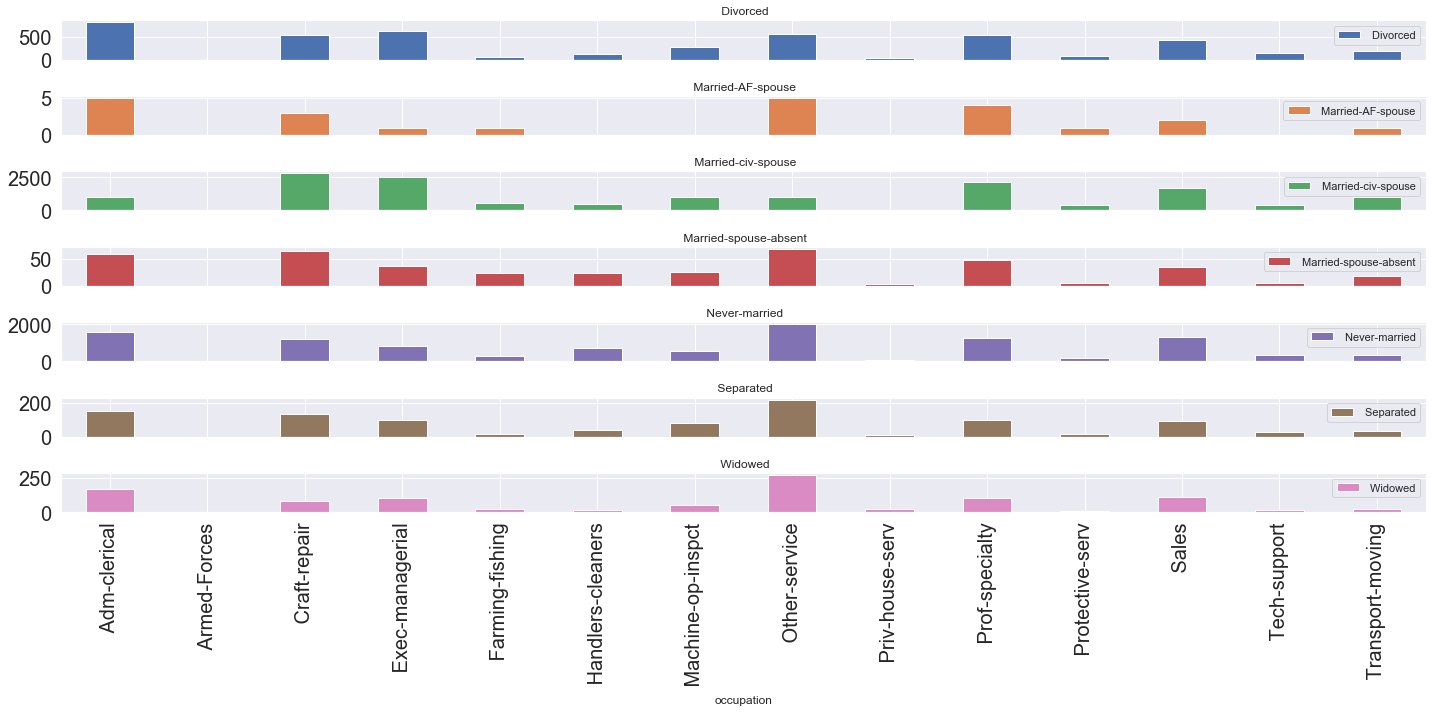

In [30]:
group_bar('marital_status','occupation')

Let's examine race grouped by marital_status.
Blacks have the highest proportion of Widowed.

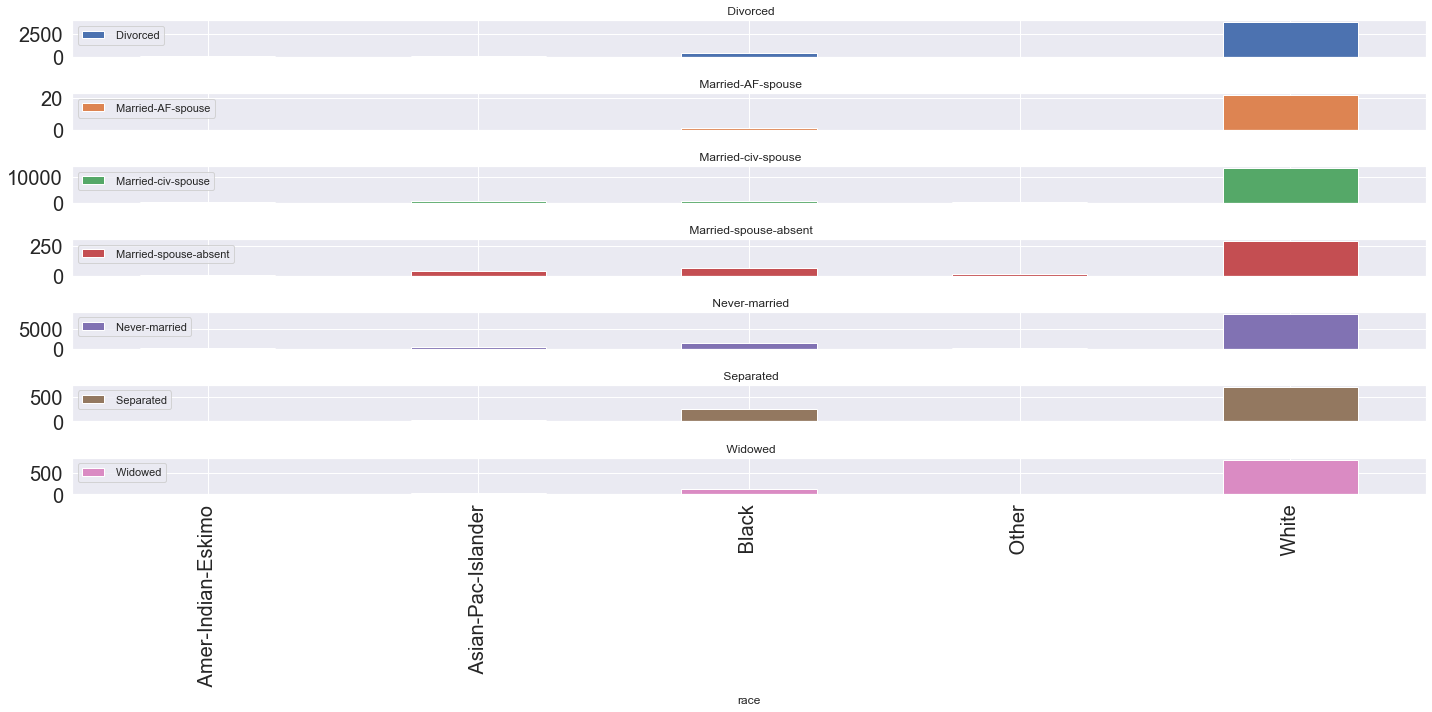

In [31]:
group_bar('marital_status','race')

Let's examine sex grouped by marital_status.
Observe that there are a lot more males than females for Married-civ-spouse &
a lot more females than males for Widowed.

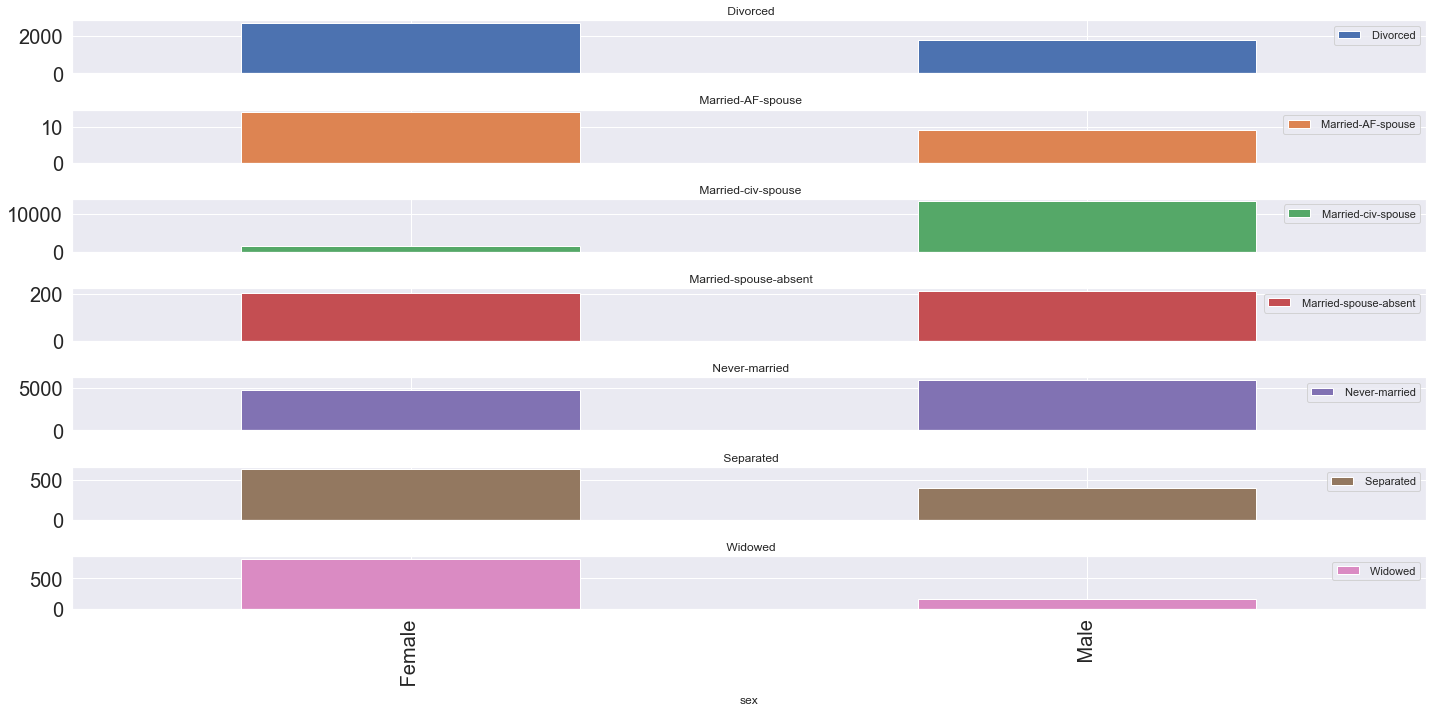

In [32]:
group_bar('marital_status','sex')

Occupation

Let's examine count of each occupation.
Most belong to Craft-repair & Armed-Forces has the least individuals.

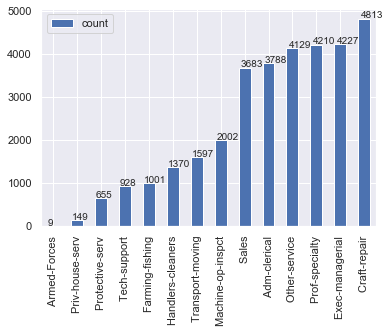

In [33]:
bar_count('occupation')

Let's examine race grouped by occupation.
Observe that most Amer-Indian-Eskimo are in the Armed-Forces &
most Asian-Pan-Islander are in Other-service & Tech-support.

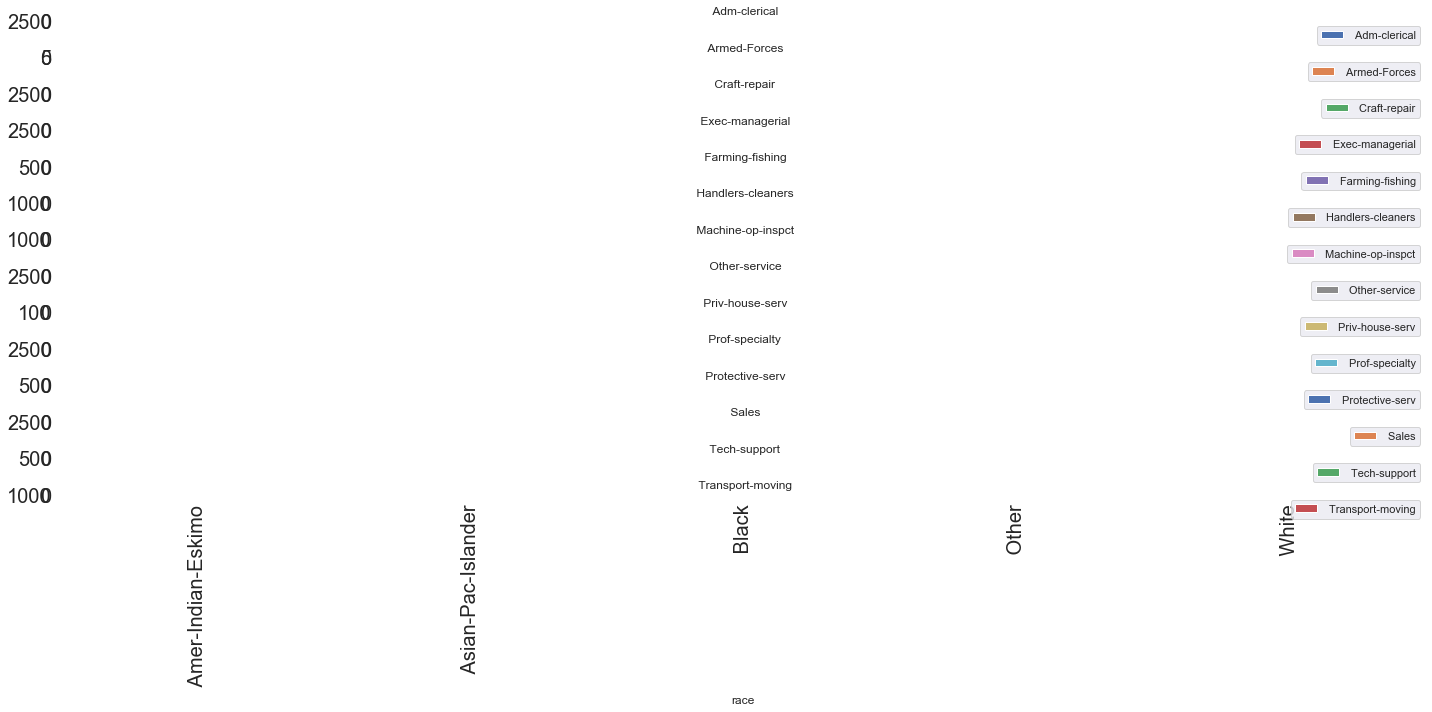

In [34]:
group_bar('occupation','race')

Let's examine sex grouped by occupation.
Observe that most clerks tend to be females & most in the Armed-Forces tend to be males.

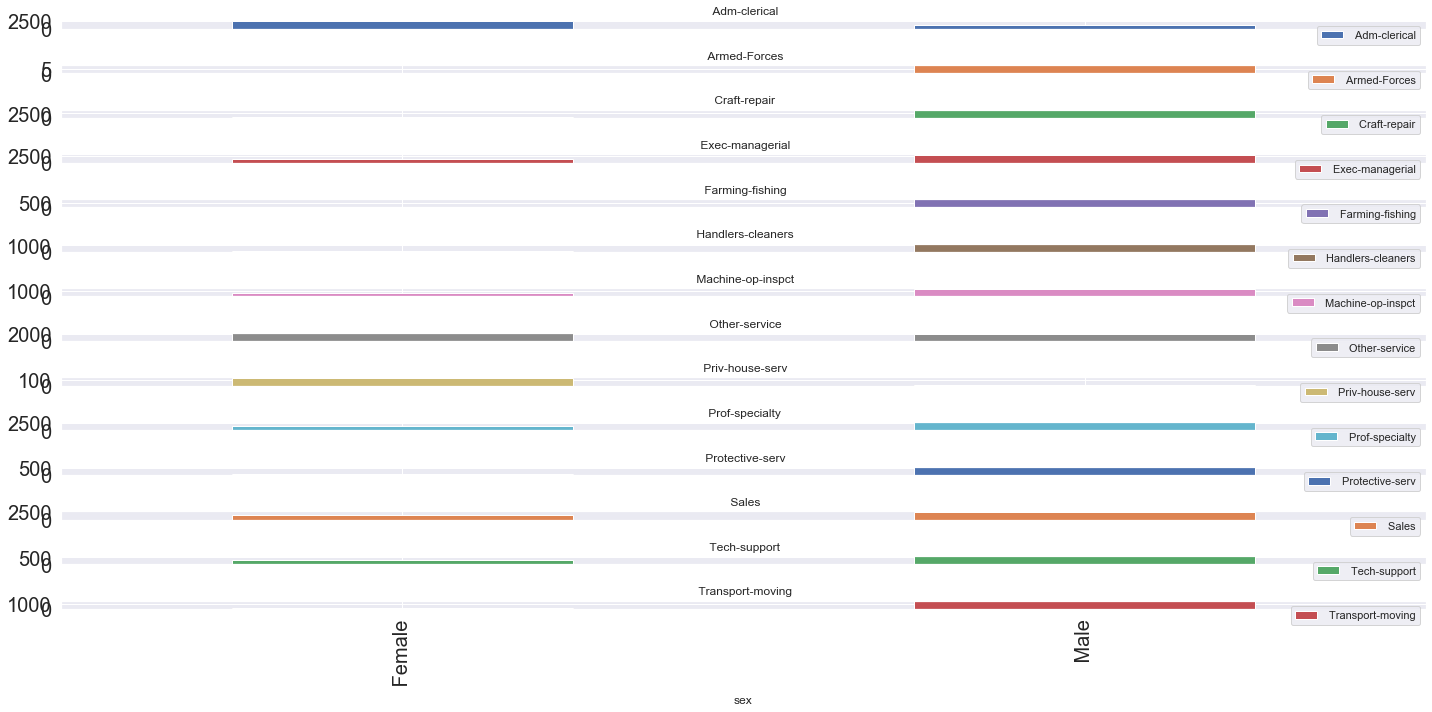

In [35]:
group_bar('occupation','sex')

Let's examine count of each relationship. 
Most are Husbands.

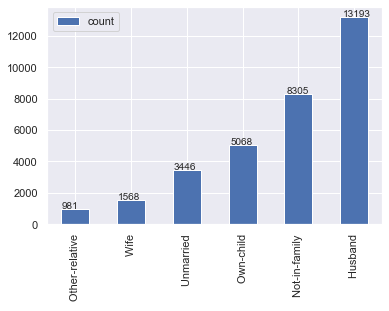

In [36]:
bar_count('relationship')

Let's examine race grouped by relationship

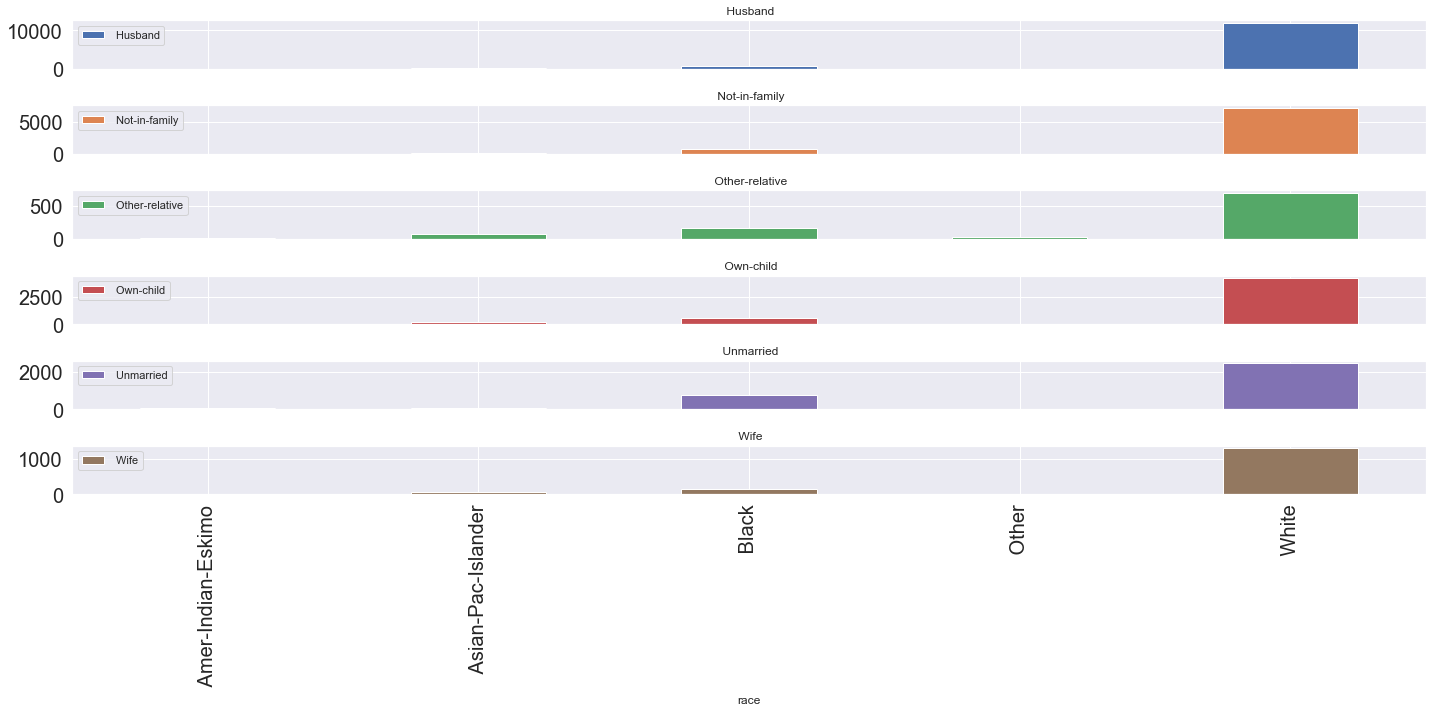

In [37]:
group_bar('relationship','race')

Let's examine sex grouped by relationship.
Interestingly, a lot more females are unmarried compared to males.

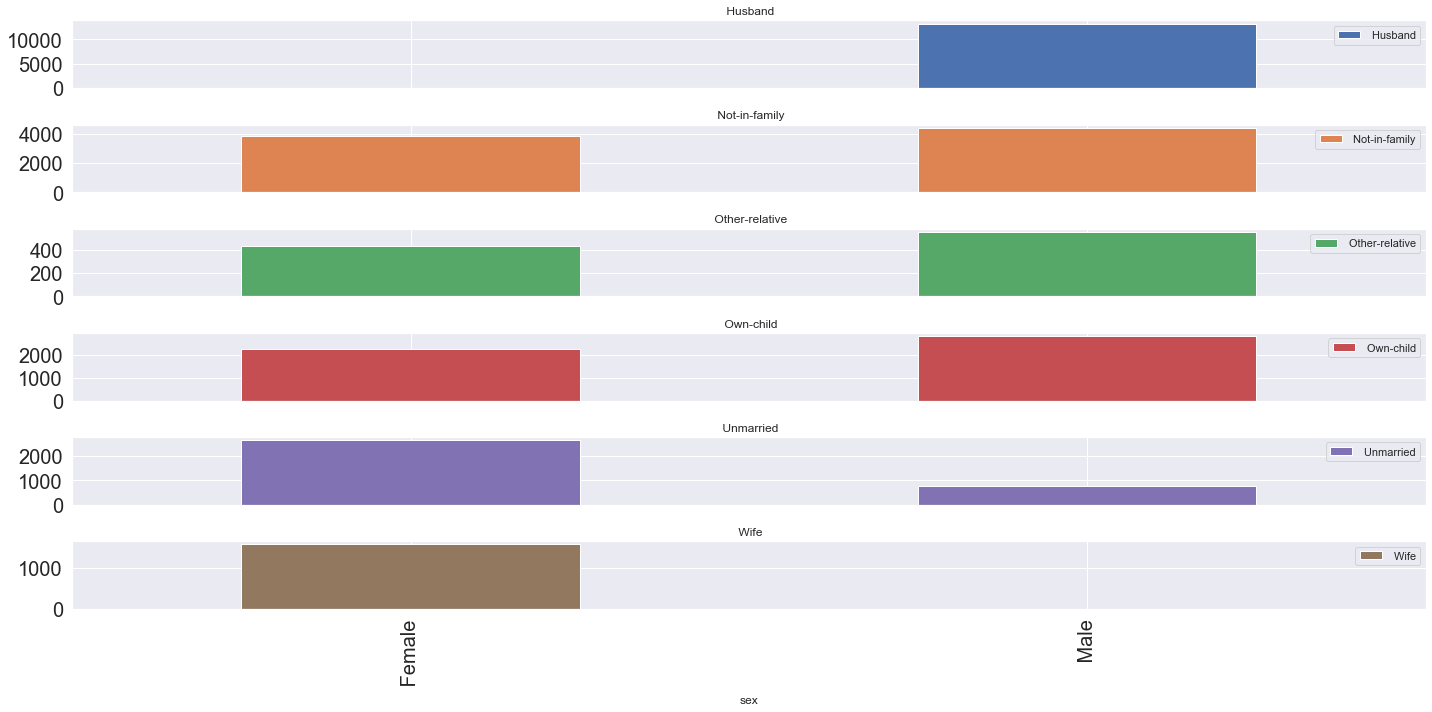

In [38]:
group_bar('relationship','sex')

Race

Let's examine count of each race.
Most individuals are whites.

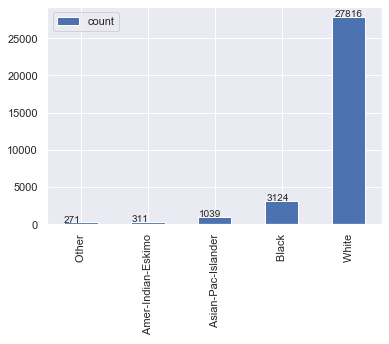

In [39]:
bar_count('race')

Let's examine sex grouped by race.
Aside from blacks, most races have more males than females.

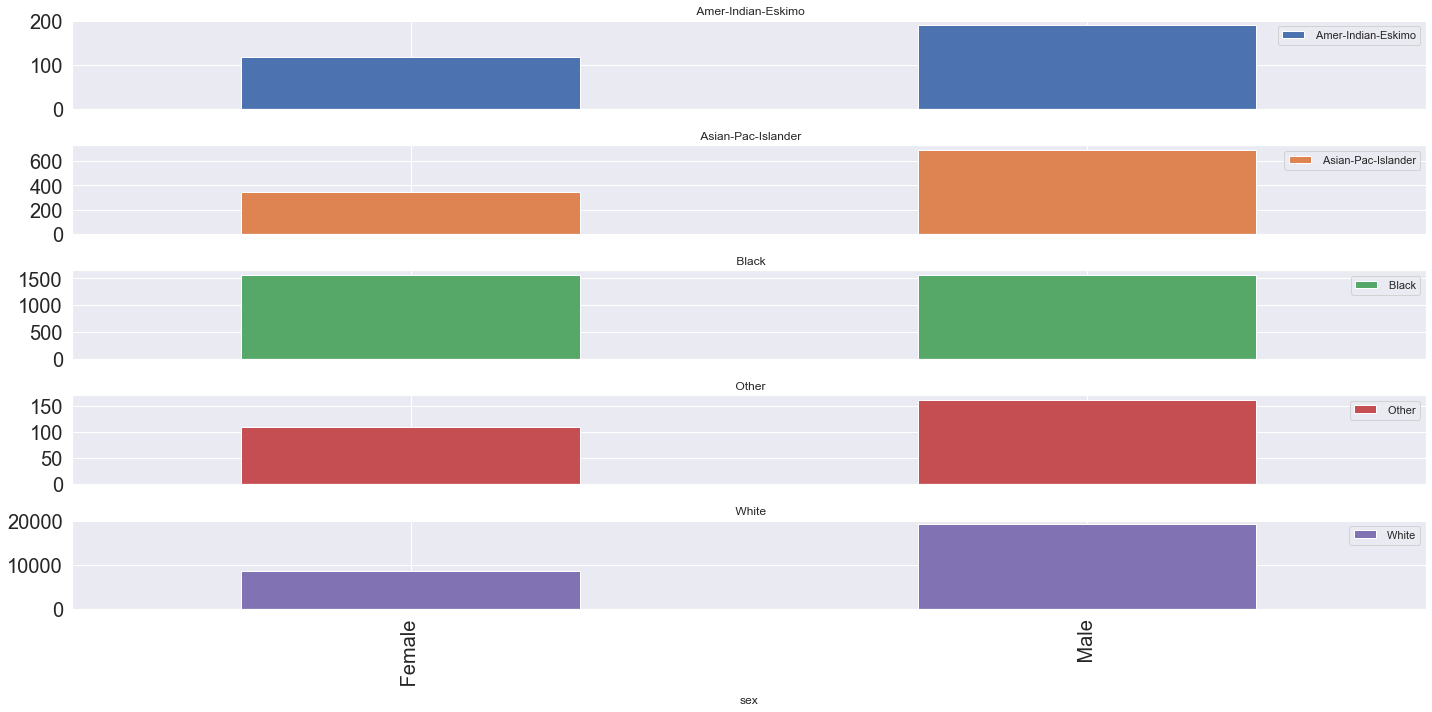

In [40]:
group_bar('race','sex')

Capital_gain

Let's examine distribution of capital_gain.
Seems that there exist some outliers close to 100000.

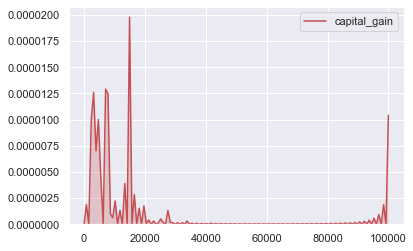

In [41]:
sns.kdeplot(main_copy['capital_gain'],shade=True,color='r')

Capital_loss

Let's examine distribution of capital_loss.
Seems that it resembles a normal-distribution

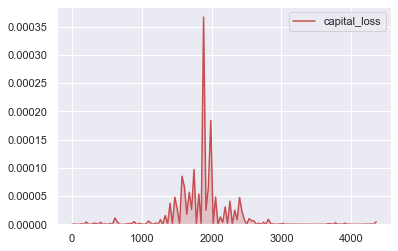

In [42]:
sns.kdeplot(main_copy['capital_loss'],shade=True,color='r')

Hours_per_week

Let's examine distribution of hours_per_week.
Seems that it resembles a normal-distribution centred at 40.

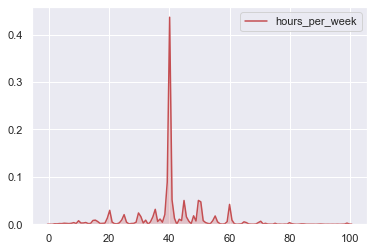

In [43]:
sns.kdeplot(main_copy['hours_per_week'],shade=True,color='r')

Native_country

Let's examine count of each native_country. 
Most are from the United States.

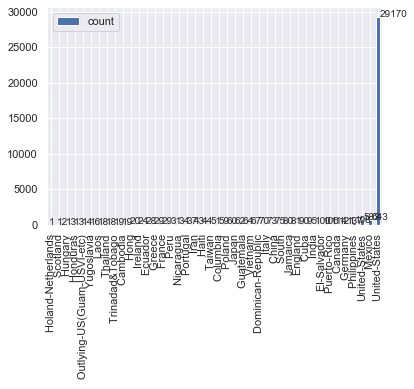

In [44]:
bar_count('native_country')

Lastly, let's check count for each income_bracket.
There exist class imbalance where individuals having <=50K is a lot more than those having >50K.
If a prediction model is to be created, this must be addressed to improve the model's predicition.

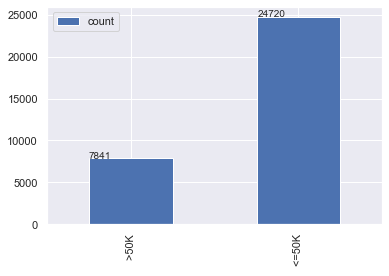

In [45]:
bar_count('income_bracket')

Let's end off the EDA section with a correlation heatmap.
There's some sort of correlation between educational_num & capital_gain/hours_per_week, suggesting a potential positive relationship between schooling years & capital_gain/hours_per_week.

In [46]:
corr = main_copy.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,functional_weight,education_num,capital_gain,capital_loss,hours_per_week
age,1,-0.0766459,0.0365272,0.0776745,0.0577745,0.0687557
functional_weight,-0.0766459,1,-0.0431946,0.000431886,-0.0102517,-0.0187685
education_num,0.0365272,-0.0431946,1,0.12263,0.079923,0.148123
capital_gain,0.0776745,0.000431886,0.12263,1,-0.0316151,0.0784086
capital_loss,0.0577745,-0.0102517,0.079923,-0.0316151,1,0.0542564
hours_per_week,0.0687557,-0.0187685,0.148123,0.0784086,0.0542564,1


# Feature Engineering

In [47]:
main_copy.columns

Index(['age', 'workclass', 'functional_weight', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income_bracket'],
      dtype='object')

Let's combine capital_gain & capital_loss into one column called net_capital_gain

In [48]:
main_copy['net_capital_gain'] = main_copy['capital_gain']-main_copy['capital_loss']

Let's one-hot encode categorical variables

In [49]:
enc = OneHotEncoder()
for i in ['workclass','education','marital_status','occupation','relationship','race','sex','native_country']:
    encoded = enc.fit_transform(main_copy[i].values.reshape(-1,1)).toarray()
    encoded_df = pd.DataFrame(encoded, columns = ["Encoded_"+i+'_'+str(int(j)) for j in range(encoded.shape[1])])
    main_copy = pd.concat([main_copy, encoded_df], axis=1)

# Feature Selection

In [50]:
main_copy.drop(['workclass','functional_weight','education','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','native_country'],axis=1,inplace=True)
main_copy.reset_index(drop=True,inplace=True)
main_copy.head()

,age,education_num,hours_per_week,income_bracket,net_capital_gain,Encoded_workclass_0,Encoded_workclass_1,Encoded_workclass_2,Encoded_workclass_3,Encoded_workclass_4,...,Encoded_native_country_32,Encoded_native_country_33,Encoded_native_country_34,Encoded_native_country_35,Encoded_native_country_36,Encoded_native_country_37,Encoded_native_country_38,Encoded_native_country_39,Encoded_native_country_40,Encoded_native_country_41
0,39,5,34,<=50K,3411,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,72,5,48,>50K,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,45,5,40,>50K,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,31,5,40,<=50K,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,55,5,23,<=50K,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Modelling

Let's split data into training & test sets. We allocate 30% of the data for test set & scale both training & test data using standardscaler.

In [51]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(main_copy.loc[:, ~main_copy.columns.isin(['income_bracket'])], main_copy['income_bracket'], test_size=0.3, random_state=123)
scaler.fit(X_train)
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns,index=X_train.index)
scaler.fit(X_test)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns,index=X_test.index)

In [52]:
scaled_X_train.shape,scaled_X_test.shape

((22792, 104), (9769, 104))

Let's implement data-augmentation to upsample minority class & reduce class-imbalance.
Below is a function that triples the minor category & doubles the major category.

In [53]:
def augment(input_X,input_y):
    #Triples minor category
    mask = input_y==' <=50K'
    x1 = input_X[mask].copy()     
    new_input_X = input_X.append(x1.sample(frac=1))
    new_input_X = new_input_X.append(x1.sample(frac=1))
    new_input_y = input_y.append(input_y[mask])
    new_input_y = new_input_y.append(input_y[mask])
    
    #Doubles major category
    mask = input_y==' >50K'
    x1 = input_X[mask].copy()
    new_input_X = new_input_X.append(x1.sample(frac=1))
    new_input_y = new_input_y.append(input_y[mask])
    return new_input_X,new_input_y

aug_input_train,aug_target_train = augment(scaled_X_train,y_train)

Prediction

In [54]:
lr = LogisticRegression(solver='lbfgs')
print(cross_val_score(lr, aug_input_train, aug_target_train, cv=5, scoring='accuracy').mean()) 

0.8718577189556045


In [55]:
clf = LogisticRegression(solver='lbfgs' ,multi_class='multinomial').fit(aug_input_train, aug_target_train)
predictions = clf.predict(scaled_X_test)

In [188]:
metrics.accuracy_score(y_test, predictions)

0.8437915856280069

Confusion Matrix

Notice that f1-score for >50K is much-lower than <=50K. This is mainly due to class-imbalance. The model performs very well for <=50K but not so well for >50K. In fact, almost all <=50K cases are correctly-classified while less than half of >50K cases are correctly-classified.

In [57]:
print(metrics.classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

       <=50K       0.86      0.96      0.90      7452
        >50K       0.77      0.48      0.60      2317

    accuracy                           0.84      9769
   macro avg       0.81      0.72      0.75      9769
weighted avg       0.84      0.84      0.83      9769



ROC 

probability threholds for every 100 points for each class is plotted on their respective ROCs. 
In fact, there exist some sort of tradeoff where decreasing the probability threshold will result in increases for true positive cases for both classes. However as this continues, the increase in false positive cases outweigh the increase in true positive cases and eventually accuracy starts to reach a maximum and decline. Here, let's set threshold as 0.45 to obtain a slightly-higher accuracy of 0.84727.

If probability exceeds threshold, model classifies it as <=50K, else >50K. Note that True Positive Rate is also the Recall, which is TP/(TP+FN). In other words, it refers to the number of correct predictions out of all positive predictions of the class. Looking at the default threshold of 0.5, notice that recall for ' >50K' is around 0.4. Referring to the above confusion matrix, observe that this is true(0.48). The same can be observed for ' <=50K' as the positive class.

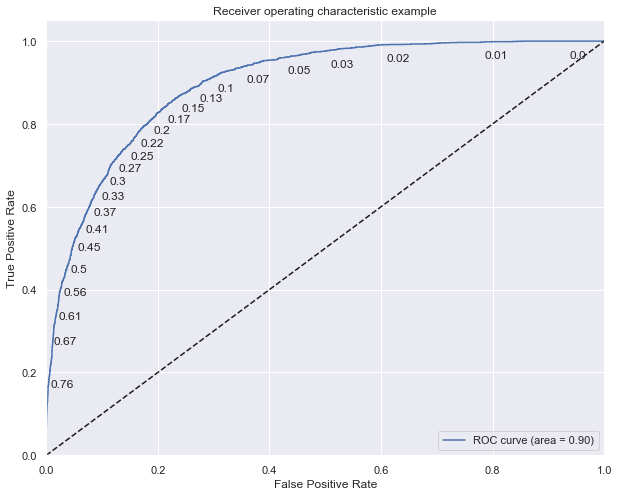

In [246]:
probs = clf.predict_proba(scaled_X_test)
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(np.array(y_test), probs[:, i], pos_label=' >50K')
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10,8))
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
for x, y, txt in zip(fpr[1][::100], tpr[1][::100], thresholds[1][::100]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()    

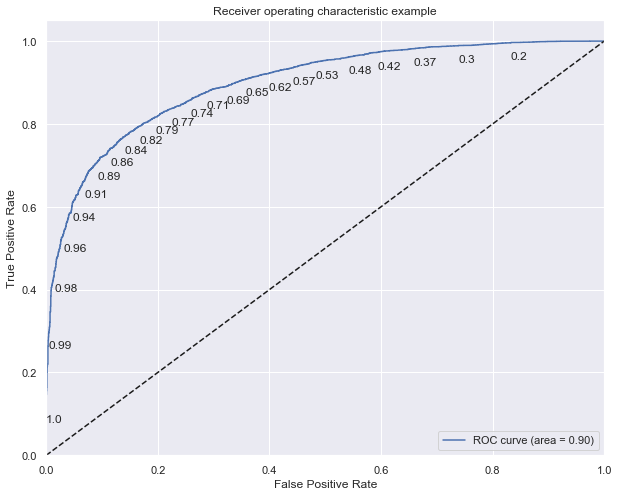

In [241]:
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(np.array(y_test), probs[:, i], pos_label=' <=50K')
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
plt.figure(figsize=(10,8))
plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], 'k--')
for x, y, txt in zip(fpr[0][::100], tpr[0][::100], thresholds[0][::100]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()   

In [234]:
preds = np.where(clf.predict_proba(scaled_X_test)[:,1] > 0.45, ' >50K', ' <=50K')
preds

array([' <=50K', ' <=50K', ' >50K', ..., ' <=50K', ' <=50K', ' <=50K'],
      dtype='<U6')

In [235]:
metrics.accuracy_score(y_test, preds)

0.8472719828027434

# Conclusion

This model proves that it is possible to obtain a good prediction of income_brackets without much feature-engineering simply by using a logistic regression. More importantly, it demonstrates that it's possible to make use of the confusion matrix & the ROC curve to select ideal probability thresholds for the logistic regression model in order to attain a higher accuracy. Users should bear in mind the tradeoff between True Positive Rate and False Positive Rate when selecting thresholds.